In [2]:
!pip install kaggle
! mkdir ~/.kaggle

import json
kaggle_token = {"username":"datastorm120","key":"8ff6645b2258b372547db6ef8b635c6c"}
with open("kaggle.json", "w") as f:
  token_json = json.dumps(kaggle_token)
  f.write(token_json)

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c data-storm-4
! unzip data-storm-4.zip 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  0% 0.00/5.77M [00:00<?, ?B/s]
100% 5.77M/5.77M [00:00<00:00, 89.3MB/s]
Archive:  data-storm-4.zip
  inflating: Data-dictionary.xlsx    
  inflating: DataStorm4.0_KaggleProblemStatement.pdf  
  inflating: Historical-transaction-data.csv  
  inflating: Store-info.csv          
  inflating: Testing-data.csv        


In [3]:
import pandas as pd
import numpy as np

store_info_data = pd.read_csv('Store-info.csv')
historical_data = pd.read_csv('Historical-transaction-data.csv')
testing_data = pd.read_csv('Testing-data.csv')

store_info_data.head()

,shop_id,shop_area_sq_ft,shop_profile
0,SHOP047,528,Moderate
1,SHOP009,676,High
2,SHOP083,676,Low
3,SHOP117,676,Low
4,SHOP042,676,Low


In [7]:


# assuming you have a DataFrame named df with the given features
# group the data by shop_id and customer_id
grouped = historical_data.groupby(['shop_id', 'customer_id'])

# calculate the total spending for each customer at each shop
total_spending = grouped.apply(lambda x: (x['item_price'] * x['quantity_sold']).sum())

# calculate the average spending for each customer at each shop
average_spending = total_spending.groupby('shop_id').mean()

# create a new DataFrame with the shop_id and average_customer_spending columns
result = pd.DataFrame({'shop_id': average_spending.index, 'average_customer_spending': average_spending.values})

print(result)

     shop_id  average_customer_spending
0    SHOP001                1328.519678
1    SHOP002                1196.916958
2    SHOP003                 931.683624
3    SHOP004                 901.204128
4    SHOP005                 975.270086
..       ...                        ...
119  SHOP123                 853.990509
120  SHOP124                1300.828584
121  SHOP125                1509.960806
122  SHOP126                1070.438101
123  SHOP127                1700.917843

[124 rows x 2 columns]


In [9]:
# assuming you have a DataFrame named df with the given features
# group the data by shop_id and customer_id
grouped = historical_data.groupby(['shop_id', 'customer_id'])

# calculate the number of distinct invoices for each customer at each shop
num_invoices = grouped['invoice_id'].nunique()

# calculate the average number of invoices for each customer at each shop
average_invoices = num_invoices.groupby('shop_id').mean()

# create a new DataFrame with the shop_id and average_transactions_customer_make columns
result = pd.DataFrame({'shop_id': average_invoices.index, 'average_transactions_customer_make': average_invoices.values})

print(result)

     shop_id  average_transactions_customer_make
0    SHOP001                            1.374776
1    SHOP002                            1.462553
2    SHOP003                            1.389050
3    SHOP004                            1.514335
4    SHOP005                            1.444848
..       ...                                 ...
119  SHOP123                            1.387403
120  SHOP124                            1.423498
121  SHOP125                            1.426652
122  SHOP126                            1.448841
123  SHOP127                            1.314078

[124 rows x 2 columns]


In [ ]:
merged_df = pd.merge(historical_data, store_info_data, on='shop_id', how='left')

merged_df.head()

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold,shop_area_sq_ft,shop_profile
0,ORANGE BARLEY 1.5L,2021-12-11T00:00:00.000Z,147.0,BGXA,SHOP008,220,2,678,Moderate
1,GINGER BEER 1.5L,2021-10-17T00:00:00.000Z,371.0,IA25,SHOP112,220,2,668,Moderate
2,TONIC PET 500ML,2021-12-13T00:00:00.000Z,484.0,VN7V,SHOP008,160,2,678,Moderate
3,CREAM SODA 1L,2021-12-13T00:00:00.000Z,484.0,VN7V,SHOP008,150,2,678,Moderate
4,STRAWBERRY MILK 180ML,2021-10-23T00:00:00.000Z,1310.0,7S00,SHOP112,210,5,668,Moderate


In [ ]:
# create a dictionary mapping item prices to their most common item descriptions
price_to_mode = merged_df.groupby('item_description')['item_price'].apply(lambda x: x.mode()[0]).to_dict()
# Loop through each row in merged_df
for index, row in merged_df.iterrows():
    # Check if item_description is null
    if pd.isnull(row['item_description']):
        # Find the item name in price_to_mode that has the same price
        item_name = [key for key, value in price_to_mode.items() if value == row['item_price']]
        # If there is a matching item name, fill the null value in item_description
        if item_name:
            merged_df.at[index, 'item_description'] = item_name[0]

null_count = merged_df['item_description'].isnull().sum()
print("Number of null values in item_description feature:", null_count)

Number of null values in item_description feature: 15503


In [ ]:
merged_df['item_price'] = merged_df.apply(lambda row: price_to_mode[row['item_description']] if pd.isnull(row['item_price']) else row['item_price'], axis=1)

null_count = merged_df['item_price'].isnull().sum()
print("Number of null values in item_price feature:", null_count)

Number of null values in item_price feature: 0


In [ ]:
merged_df.dropna(subset=['item_description'], inplace=True)

null_count = merged_df['item_description'].isnull().sum()
print("Number of null values in item_description feature:", null_count)

Number of null values in item_description feature: 0


In [ ]:
merged_df.dropna(subset=['invoice_id'], inplace=True)

null_count = merged_df['invoice_id'].isnull().sum()
print("Number of null values in invoice_id feature:", null_count)

Number of null values in invoice_id feature: 0


In [ ]:
# Select columns with numeric data types
numeric_cols = merged_df.select_dtypes(include=[int, float])

# Drop rows with negative values in any numeric column
merged_df = merged_df.drop(numeric_cols[(numeric_cols < 0).any(1)].index)

<ipython-input-8-e7cf8abd89dd>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  merged_df = merged_df.drop(numeric_cols[(numeric_cols < 0).any(1)].index)


In [ ]:
from sklearn.preprocessing import LabelEncoder

# instantiate a LabelEncoder object
le = LabelEncoder()

# label encode the item_description, customer_id, and shop_profile columns
merged_df['item_description'] = le.fit_transform(merged_df['item_description'])
merged_df['customer_id'] = le.fit_transform(merged_df['customer_id'])

# replace the values in the shop_profile column with 1 for High, 2 for Moderate, and 3 for Low
merged_df['shop_profile'] = merged_df['shop_profile'].replace({'Low':3, 'Moderate':2, 'High':1})

merged_df.head()

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold,shop_area_sq_ft,shop_profile
0,27,2021-12-11T00:00:00.000Z,147.0,59378,SHOP008,220,2,678,2.0
1,14,2021-10-17T00:00:00.000Z,371.0,94694,SHOP112,220,2,668,2.0
2,35,2021-12-13T00:00:00.000Z,484.0,163963,SHOP008,160,2,678,2.0
3,4,2021-12-13T00:00:00.000Z,484.0,163963,SHOP008,150,2,678,2.0
4,34,2021-10-23T00:00:00.000Z,1310.0,40280,SHOP112,210,5,668,2.0


In [ ]:
# Parse the transaction_date column as a datetime object
merged_df['transaction_date'] = pd.to_datetime(merged_df['transaction_date'])

# Extract relevant features from the transaction_date column
merged_df['year'] = merged_df['transaction_date'].dt.year
merged_df['month'] = merged_df['transaction_date'].dt.month
merged_df['day_of_week'] = merged_df['transaction_date'].dt.dayofweek
merged_df['hour'] = merged_df['transaction_date'].dt.hour

merged_df = merged_df.drop('transaction_date', axis=1)

merged_df.head()

,item_description,invoice_id,customer_id,shop_id,item_price,quantity_sold,shop_area_sq_ft,shop_profile,year,month,day_of_week,hour
0,27,147.0,59378,SHOP008,220,2,678,2.0,2021,12,5,0
1,14,371.0,94694,SHOP112,220,2,668,2.0,2021,10,6,0
2,35,484.0,163963,SHOP008,160,2,678,2.0,2021,12,0,0
3,4,484.0,163963,SHOP008,150,2,678,2.0,2021,12,0,0
4,34,1310.0,40280,SHOP112,210,5,668,2.0,2021,10,5,0


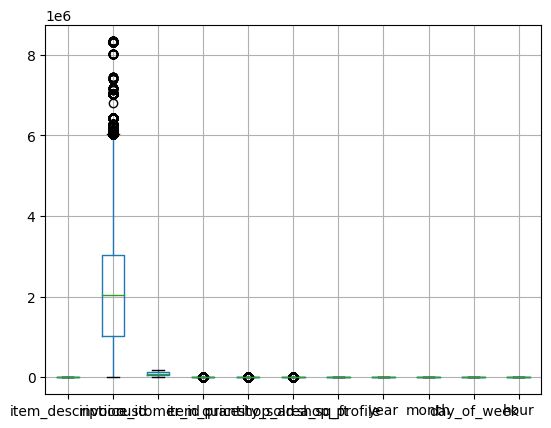

In [ ]:
import matplotlib.pyplot as plt

# Create a list of columns to plot
columns_to_plot = ['item_description', 'invoice_id', 'customer_id', 'item_price', 'quantity_sold', 'shop_area_sq_ft', 'shop_profile', 'year', 'month', 'day_of_week', 'hour']

# Create a boxplot for each column
merged_df[columns_to_plot].boxplot()
plt.show()

In [ ]:
# Group merged_df by shop_id
grouped = merged_df.groupby('shop_id')

# Calculate total sales for each shop
total_sales = grouped['item_price'].sum()

# Calculate average transaction value for each shop
avg_transaction_value = grouped['item_price'].mean()

# Calculate number of unique customers for each shop
num_unique_customers = grouped['customer_id'].nunique()

# Calculate most popular item for each shop
most_popular_item = grouped['item_description'].agg(lambda x:x.value_counts().index[0])

# Calculate total quantity sold for each shop
total_quantity_sold = grouped['quantity_sold'].sum()

# Calculate average item price for each shop
avg_item_price = grouped['item_price'].mean()

# Calculate number of unique items for each shop
num_unique_items = grouped['item_description'].nunique()

# Calculate most expensive item for each shop
most_expensive_item = grouped.apply(lambda x: x.loc[x['item_price'].idxmax(), "item_description"])

# Merge calculated features into store_info_data DataFrame
store_info_data = store_info_data.merge(total_sales.rename('total_sales'), how='left', on='shop_id')
store_info_data = store_info_data.merge(avg_transaction_value.rename('avg_transaction_value'), how='left', on='shop_id')
store_info_data = store_info_data.merge(num_unique_customers.rename('num_unique_customers'), how='left', on='shop_id')
store_info_data = store_info_data.merge(most_popular_item.rename('most_popular_item'), how='left', on='shop_id')
store_info_data = store_info_data.merge(total_quantity_sold.rename('total_quantity_sold'), how='left', on='shop_id')
store_info_data = store_info_data.merge(avg_item_price.rename('avg_item_price'), how='left', on='shop_id')
store_info_data = store_info_data.merge(num_unique_items.rename('num_unique_items'), how='left', on='shop_id')
store_info_data = store_info_data.merge(most_expensive_item.rename('most_expensive_item'), how='left', on='shop_id')

# Calculate sales per square foot for each shop
store_info_data['sales_per_sq_ft'] = store_info_data['total_sales'] / store_info_data['shop_area_sq_ft']

# Calculate average transaction value per square foot for each shop
store_info_data['avg_transaction_value_per_sq_ft'] = store_info_data['avg_transaction_value'] / store_info_data['shop_area_sq_ft']

# Calculate average item price per square foot for each shop
store_info_data['avg_item_price_per_sq_ft'] = store_info_data['avg_item_price'] / store_info_data['shop_area_sq_ft']

# Calculate the total number of transactions per day for each shop
transactions_per_day = merged_df.groupby(['shop_id', 'year', 'month', 'day_of_week'])['invoice_id'].nunique().reset_index(name='transactions')

# Calculate the average number of transactions per day for each shop
avg_transactions_per_day = transactions_per_day.groupby('shop_id')['transactions'].mean().reset_index(name='avg_transactions_per_day')

# Merge the result with the store_info_data dataframe
store_info_data = store_info_data.merge(avg_transactions_per_day, on='shop_id', how='left')

# Display final store_info_data DataFrame
store_info_data.head()

,shop_id,shop_area_sq_ft,shop_profile,total_sales,avg_transaction_value,num_unique_customers,most_popular_item,total_quantity_sold,avg_item_price,num_unique_items,most_expensive_item,sales_per_sq_ft,avg_transaction_value_per_sq_ft,avg_item_price_per_sq_ft,avg_transactions_per_day
0,SHOP047,528,Moderate,319755,199.472863,890,14,2979,199.472863,36,17,605.596591,0.377790,0.377790,59.000000
1,SHOP009,676,High,818470,188.240570,2398,14,7668,188.240570,36,10,1210.754438,0.278462,0.278462,160.476190
2,SHOP083,676,Low,707410,203.395630,1831,14,6236,203.395630,36,27,1046.464497,0.300881,0.300881,125.619048
3,SHOP117,676,Low,855540,218.083100,1985,14,7558,218.083100,37,33,1265.591716,0.322608,0.322608,146.857143
4,SHOP042,676,Low,591515,188.982428,1775,14,5417,188.982428,36,27,875.022189,0.279560,0.279560,115.238095


In [ ]:
store_info_data['shop_profile'] = store_info_data['shop_profile'].replace({0: 'High', 1: 'Moderate', 2: 'Low'})
 
store_info_data.head()

,shop_id,shop_area_sq_ft,shop_profile,total_sales,avg_transaction_value,num_unique_customers,most_popular_item,total_quantity_sold,avg_item_price,num_unique_items,most_expensive_item,sales_per_sq_ft,avg_transaction_value_per_sq_ft,avg_item_price_per_sq_ft,avg_transactions_per_day
0,SHOP047,528,Moderate,319755,199.472863,890,14,2979,199.472863,36,17,605.596591,0.377790,0.377790,59.000000
1,SHOP009,676,High,818470,188.240570,2398,14,7668,188.240570,36,10,1210.754438,0.278462,0.278462,160.476190
2,SHOP083,676,Low,707410,203.395630,1831,14,6236,203.395630,36,27,1046.464497,0.300881,0.300881,125.619048
3,SHOP117,676,Low,855540,218.083100,1985,14,7558,218.083100,37,33,1265.591716,0.322608,0.322608,146.857143
4,SHOP042,676,Low,591515,188.982428,1775,14,5417,188.982428,36,27,875.022189,0.279560,0.279560,115.238095


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Create an instance of the MinMaxScaler
scaler = MinMaxScaler()

# Select the columns to scale
cols_to_scale = store_info_data.select_dtypes(include=['float64', 'int64']).columns

# Fit the scaler to the selected columns and transform them
store_info_data[cols_to_scale] = scaler.fit_transform(store_info_data[cols_to_scale])

In [ ]:
train = store_info_data[store_info_data['shop_profile'].notnull()]

print(len(train))

100


In [ ]:
test = store_info_data[store_info_data['shop_profile'].isnull()]

print(len(test))

24


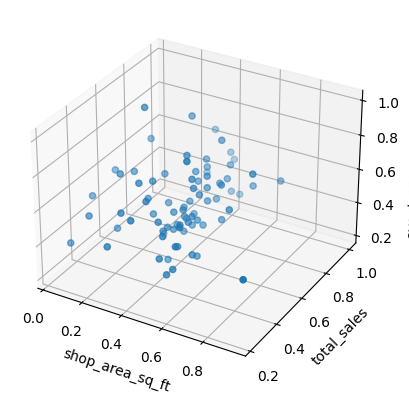

Accuracy: 0.60
F1 Score: 0.59
452
Accuracy: 0.74
F1 Score: 0.74
452


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import mutual_info_classif

# # Split data into predictors and target variable
# X = final_df.drop(['shop_profile', 'shop_id'], axis=1)
# y = final_df['shop_profile']


# # Select the top 5 features using chi2 scoring function
# k_best = SelectKBest(score_func=chi2, k=3)
# X = k_best.fit_transform(X, y)

# random_state = np.random.randint(1, 1000)
# # random_state = 401
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)


# Split data into predictors and target variable
X = train.drop(['shop_profile', 'shop_id'], axis=1)
y = train['shop_profile']

# Select the top 3 features using mutual information scoring function
# k_best = SelectKBest(score_func=mutual_info_classif, k=3)
# X = k_best.fit_transform(X, y)


random_state = np.random.randint(1, 1000)
# random_state = 55
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
X_train = pd.DataFrame(X_train)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = X_train.iloc[:, 0]
y = X_train.iloc[:, 1]
z = X_train.iloc[:, 2]

ax.scatter(x, y, z)

ax.set_xlabel(X_train.columns[0])
ax.set_ylabel(X_train.columns[1])
ax.set_zlabel(X_train.columns[2])

plt.show()
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Create an instance of the logistic regression classifier
clf = LogisticRegression(C=500,max_iter=1000)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate the accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.2f}')
print(f'F1 Score: {f1:.2f}')
print(random_state)

# Make predictions on the test data
y_pred2 = clf.predict(X_train)

# Calculate the accuracy and F1 score
accuracy2 = accuracy_score(y_train, y_pred2)
f12 = f1_score(y_train, y_pred2, average='weighted')

print(f'Accuracy: {accuracy2:.2f}')
print(f'F1 Score: {f12:.2f}')


print(random_state)
# 55 875 73 9

In [ ]:
from sklearn.svm import SVC

# Create an instance of the SVM classifier
clf = SVC(C=1.0, kernel='rbf', gamma='scale')

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate the accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.2f}')
print(f'F1 Score: {f1:.2f}')

# Make predictions on the training data
y_pred2 = clf.predict(X_train)

# Calculate the accuracy and F1 score
accuracy2 = accuracy_score(y_train, y_pred2)
f12 = f1_score(y_train, y_pred2, average='weighted')

print(f'Training Accuracy: {accuracy2:.2f}')
print(f'Training F1 Score: {f12:.2f}')

ValueError: ignored

In [ ]:
historical_data.head()

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold
0,ORANGE BARLEY 1.5L,2021-12-11T00:00:00.000Z,147.0,BGXA,SHOP008,220,2
1,GINGER BEER 1.5L,2021-10-17T00:00:00.000Z,371.0,IA25,SHOP112,220,2
2,TONIC PET 500ML,2021-12-13T00:00:00.000Z,484.0,VN7V,SHOP008,160,2
3,CREAM SODA 1L,2021-12-13T00:00:00.000Z,484.0,VN7V,SHOP008,150,2
4,STRAWBERRY MILK 180ML,2021-10-23T00:00:00.000Z,1310.0,7S00,SHOP112,210,5


In [ ]:
historical_data['item_description'].unique()

array(['ORANGE BARLEY 1.5L', 'GINGER BEER 1.5L', 'TONIC PET 500ML',
       'CREAM SODA 1L', 'STRAWBERRY MILK 180ML', 'CREAM SODA 1.5L',
       'TWISTEE APPLE 1L', 'FIT O MIXED FRUIT 200ML', 'SODA PET 1.5L',
       'FIT O MIXED FRUIT 1L', 'KIK COLA 1L', 'LEMONADE 500ML',
       'FIT O ORANGE 1L', 'NECTO 1.5L', 'LEMONADE 1.5L', 'GINGER BEER 1L',
       'FIT O MANGO 200ML', 'FIT O MANGO 1L', 'CREAM SODA 500ML',
       'FIT O ORANGE 200ML', nan, 'CREAM SODA APPLE POP 1L',
       'BOTTLED DRINKING WATER 500ML', 'SODA 500ML', 'GINGER BEER 500ML',
       'SODA 1L', 'NECTO 500ML', 'ORANGE CRUSH 500ML',
       'BOTTLED DRINKING WATER 1.5L', 'NECTO 1L',
       'GINGER BEER SUGAR FREE 500ML', 'ORANGE CRUSH 1.5L',
       'DRY GINGER ALE PET 500ML', 'LEMONADE 1L', 'ORANGE CRUSH 1L',
       'GINGER BEER 400ML', 'CHOCOLATE MILK 180ML', 'LIME CRUSH JUICE 1L'],
      dtype=object)

In [ ]:
historical_data.groupby(['shop_id', 'customer_id']).size()



shop_id  customer_id
SHOP001  00DD           1
         00G3           2
         01XI           5
         024E           2
         02WN           1
                       ..
SHOP127  ZX5A           5
         ZXKD           1
         ZY1M           1
         ZYDF           2
         ZZQI           1
Length: 249939, dtype: int64

In [ ]:
 a = historical_data['customer_id'][historical_data.groupby(['customer_id', 'shop_id']).size() > 1]

IndexingError: ignored

In [ ]:
}a

customer_id  shop_id
0.00E+00     SHOP010    1
             SHOP034    1
             SHOP049    3
             SHOP056    1
             SHOP071    1
                       ..
ZZZC         SHOP019    1
ZZZE         SHOP096    1
ZZZS         SHOP070    1
ZZZW         SHOP073    2
             SHOP074    3
Length: 249939, dtype: int64

In [ ]:
len(historical_data['customer_id'].unique())

191636

In [ ]:
# group the data by shop_id and customer_id and calculate the total spending for each customer in each shop
shop_customer_spending = historical_data.groupby(['shop_id', 'customer_id']).apply(lambda x: (x['item_price'] * x['quantity_sold']).sum())

# calculate the average spending per customer for each shop
average_spending = shop_customer_spending.groupby('shop_id').mean()

# create a new DataFrame with shop_id as the unique identifier and the average spending per customer for each shop
result = pd.DataFrame({'shop_id': average_spending.index, 'average_spending_per_customer': average_spending.values})

print(result)

     shop_id  average_spending_per_customer
0    SHOP001                    1328.519678
1    SHOP002                    1196.916958
2    SHOP003                     931.683624
3    SHOP004                     901.204128
4    SHOP005                     975.270086
..       ...                            ...
119  SHOP123                     853.990509
120  SHOP124                    1300.828584
121  SHOP125                    1509.960806
122  SHOP126                    1070.438101
123  SHOP127                    1700.917843

[124 rows x 2 columns]


In [ ]:
shop_invoice_cost = historical_data.groupby(['shop_id', 'invoice_id']).apply(lambda x: (x['item_price'] * x['quantity_sold']).sum())

# calculate the average spending per customer for each shop
average_bill = shop_invoice_cost.groupby('shop_id').mean()

# create a new DataFrame with shop_id as the unique identifier and the average spending per customer for each shop
result = pd.DataFrame({'shop_id': average_bill.index, 'average_spending_per_invoice': average_bill.values})

In [ ]:
print(result)

     shop_id  average_spending_per_invoice
0    SHOP001                    952.508133
1    SHOP002                    814.360573
2    SHOP003                    664.782002
3    SHOP004                    585.130632
4    SHOP005                    647.866792
..       ...                           ...
119  SHOP123                    586.299751
120  SHOP124                    890.446566
121  SHOP125                    925.514129
122  SHOP126                    728.261803
123  SHOP127                   1264.241289

[124 rows x 2 columns]


In [ ]:
dummy = historical_data.groupby(['item_description', 'item_price'])

In [ ]:
res = pd.DataFrame(dummy)

In [ ]:
res1 = res.groupby('item_description').mean()

KeyError: ignored

In [ ]:
dummy


In [ ]:
grouped_data = historical_data.groupby(['shop_id','item_description', 'item_price'])

# perform calculations on the grouped data
# for example, to calculate the total quantity sold for each group:
total_quantity = grouped_data['quantity_sold'].sum()
pd.set_option('display.max_rows', 100)
print(total_quantity)

shop_id  item_description             item_price
SHOP001  BOTTLED DRINKING WATER 1.5L  70            32
                                      140            8
                                      210            8
                                      280            5
                                      630           10
                                                    ..
SHOP127  TONIC PET 500ML              4000          26
         TWISTEE APPLE 1L             270           34
                                      290            2
                                      540            4
                                      810            2
Name: quantity_sold, Length: 19728, dtype: int64


In [ ]:

print(total_quantity['SHOP001']['BOTTLED DRINKING WATER 1.5L'])

item_price
70     32
140     8
210     8
280     5
630    10
Name: quantity_sold, dtype: int64


In [ ]:
mean_price_group = historical_data.groupby('item_description')

mean_price = mean_price_group['item_price'].mean()

print(mean_price)

item_description
BOTTLED DRINKING WATER 1.5L     106.005003
BOTTLED DRINKING WATER 500ML     77.250095
CHOCOLATE MILK 180ML            270.375000
CREAM SODA 1.5L                 292.896385
CREAM SODA 1L                   165.744275
CREAM SODA 500ML                118.251748
CREAM SODA APPLE POP 1L         185.352761
DRY GINGER ALE PET 500ML        247.716322
FIT O MANGO 1L                  328.948079
FIT O MANGO 200ML               115.135007
FIT O MIXED FRUIT 1L            335.763616
FIT O MIXED FRUIT 200ML         119.121817
FIT O ORANGE 1L                 361.777547
FIT O ORANGE 200ML              125.300316
GINGER BEER 1.5L                264.335160
GINGER BEER 1L                  165.935542
GINGER BEER 400ML               131.076923
GINGER BEER 500ML               125.295251
GINGER BEER SUGAR FREE 500ML    109.819398
KIK COLA 1L                     138.395522
LEMONADE 1.5L                   249.332241
LEMONADE 1L                     135.391539
LEMONADE 500ML                  119.0

In [ ]:
mean_count_group = historical_data.groupby('item_description')

mean_count = mean_count_group['item_price'].unique()

print(mean_count)

item_description
BOTTLED DRINKING WATER 1.5L     [140, 70, 280, 420, 210, 560, 350, 490, 700, 6...
BOTTLED DRINKING WATER 500ML    [70, 35, 210, 245, 175, 105, 280, 805, 840, 14...
CHOCOLATE MILK 180ML            [350, 140, 70, 210, 280, 700, 1050, 490, 840, ...
CREAM SODA 1.5L                 [220, 660, 440, 880, 1100, 1320, 1540, 2200, 2...
CREAM SODA 1L                    [150, 300, 450, 600, 750, 1050, 900, 1200, 1500]
CREAM SODA 500ML                [100, 200, 300, 600, 400, 1000, 500, 1100, 700...
CREAM SODA APPLE POP 1L                      [150, 750, 450, 300, 600, 900, 1950]
DRY GINGER ALE PET 500ML        [320, 480, 300, 160, 150, 640, 1280, 450, 2400...
FIT O MANGO 1L                  [290, 270, 580, 810, 540, 870, 1080, 1450, 232...
FIT O MANGO 200ML               [60, 120, 360, 70, 180, 240, 480, 140, 490, 72...
FIT O MIXED FRUIT 1L            [290, 270, 580, 810, 870, 540, 2700, 1450, 261...
FIT O MIXED FRUIT 200ML         [60, 120, 360, 240, 180, 280, 140, 70, 900, 30...

In [ ]:
# assuming the data is stored in a DataFrame called historical_data

# group the data by shop_id and item_description
grouped_data = historical_data.groupby(['shop_id', 'item_description'])

# calculate the total revenue for each group by multiplying the item price by the quantity sold and summing the result
total_revenue = (grouped_data['item_price'] * grouped_data['quantity_sold']).sum()

# calculate the average revenue for each group by dividing the total revenue by the number of unique items in each group
average_revenue = total_revenue / grouped_data['item_description'].nunique()

# print the result
print(average_revenue)

TypeError: ignored

In [ ]:
# grouped_data = historical_data.groupby(['shop_id','item_description', 'item_price'])

# # calculate the total revenue for each group
# grouped_data['revenue'] = grouped_data['quantity_sold'] * grouped_data['item_price']

# # calculate the average revenue for each item by shop
# average_revenue = grouped_data['revenue'].mean()

# pd.set_option('display.max_rows', 100)
# print(average_revenue)


# grouped_data = historical_data.groupby(['shop_id', 'item_description', 'item_price'])

# # define a custom function to calculate revenue for each group
# def calculate_revenue(group):
#     return (group['quantity_sold'] * group['item_price']).sum()

# # apply the custom function to calculate revenue for each group
# grouped_data['revenue'] = grouped_data.apply(calculate_revenue)

# # calculate the average revenue for each item by shop
# average_revenue = grouped_data.groupby(['shop_id', 'item_description'])['revenue'].mean()

# pd.set_option('display.max_rows', 100)
# print(average_revenue)


grouped_data = historical_data.groupby(['shop_id', 'item_description', 'item_price'])

# define a custom function to calculate revenue for each group
def calculate_revenue(group):
    return (group['quantity_sold'] * group['item_price']).sum()

# apply the custom function to calculate revenue for each group
revenue_data = grouped_data.apply(calculate_revenue).reset_index(name='revenue')

# calculate the average revenue for each item by shop
average_revenue = revenue_data.groupby(['shop_id', 'item_description'])['revenue'].mean()

pd.set_option('display.max_rows', 100)
print(average_revenue)


shop_id  item_description            
SHOP001  BOTTLED DRINKING WATER 1.5L      2548.000000
         BOTTLED DRINKING WATER 500ML    11608.333333
         CREAM SODA 1.5L                 21926.666667
         CREAM SODA 1L                    4350.000000
         CREAM SODA 500ML                 9150.000000
                                             ...     
SHOP127  SODA 500ML                      11180.909091
         SODA PET 1.5L                    8936.000000
         STRAWBERRY MILK 180ML            3511.666667
         TONIC PET 500ML                 34120.714286
         TWISTEE APPLE 1L                 3385.000000
Name: revenue, Length: 4323, dtype: float64


In [ ]:
type(average_revenue)

pandas.core.series.Series

In [ ]:
average_revenue.head()

shop_id  item_description            
SHOP001  BOTTLED DRINKING WATER 1.5L      2548.000000
         BOTTLED DRINKING WATER 500ML    11608.333333
         CREAM SODA 1.5L                 21926.666667
         CREAM SODA 1L                    4350.000000
         CREAM SODA 500ML                 9150.000000
Name: revenue, dtype: float64

In [ ]:
type(historical_data)

pandas.core.frame.DataFrame

In [ ]:
average_revenue_df = average_revenue.reset_index().rename(columns={'revenue': 'average_revenue'})


In [ ]:
average_revenue_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
shop_id,4323,124,SHOP127,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
item_description,4323,37,BOTTLED DRINKING WATER 1.5L,124,NaN,NaN,NaN,NaN,NaN,NaN,NaN
average_revenue,4323.0,NaN,NaN,NaN,11282.06925,13657.543727,70.0,3058.857143,6013.333333,13563.333333,141735.555556


In [ ]:
grouped_data = historical_data.groupby(['shop_id', 'item_description', 'item_price'])

# define a custom function to calculate revenue for each group
def calculate_revenue(group):
    return group['item_price'].mean()

# apply the custom function to calculate revenue for each group
revenue_data = grouped_data.apply(calculate_revenue).reset_index(name='avg_price')

# calculate the average revenue for each item by shop
average_revenue = revenue_data.groupby(['shop_id', 'item_description'])['avg_price']

pd.set_option('display.max_rows', 100)
print(average_revenue)

In [ ]:
grouped_data = historical_data.groupby(['shop_id','item_description', 'item_price'])

# perform calculations on the grouped data
# for example, to calculate the total quantity sold for each group:
total_quantity = grouped_data['item_price'].mean()
pd.set_option('display.max_rows', 100)
print(total_quantity)

shop_id  item_description             item_price
SHOP001  BOTTLED DRINKING WATER 1.5L  70              70.0
                                      140            140.0
                                      210            210.0
                                      280            280.0
                                      630            630.0
                                                     ...  
SHOP127  TONIC PET 500ML              4000          4000.0
         TWISTEE APPLE 1L             270            270.0
                                      290            290.0
                                      540            540.0
                                      810            810.0
Name: item_price, Length: 19728, dtype: float64
